<a href="https://colab.research.google.com/github/SumeetChougule/PM-HR/blob/main/notebooks/Force_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Git clone

In [1]:
!git clone https://github.com/DifferentiableUniverseInitiative/flowpm.git
!pip install git+https://github.com/DifferentiableUniverseInitiative/flowpm.git

Cloning into 'flowpm'...
remote: Enumerating objects: 3470, done.
remote: Counting objects: 100% (1315/1315), done.
remote: Compressing objects: 100% (464/464), done.
remote: Total 3470 (delta 855), reused 1228 (delta 831), pack-reused 2155
Receiving objects: 100% (3470/3470), 65.55 MiB | 38.12 MiB/s, done.
Resolving deltas: 100% (2284/2284), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DifferentiableUniverseInitiative/flowpm.git to /tmp/pip-req-build-j7wa0rbz
  Running command git clone -q https://github.com/DifferentiableUniverseInitiative/flowpm.git /tmp/pip-req-build-j7wa0rbz
     |████████████████████████████████| 385 kB 12.1 MB/s 
     |████████████████████████████████| 221 kB 49.3 MB/s 
     |████████████████████████████████| 1.1 MB 46.5 MB/s 
  Created wheel for flowpm: filename=flowpm-0.1.2.dev252+g8f9415b-py3-none-any.whl size=45196 sha256=d7335baf7729d1b18f089fc094190158198087ccd19ff294c

## Modules

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from tensorflow.keras import datasets, layers, models, losses

import tensorflow_probability as tfp
tfd = tfp.distributions

import flowpm
from astropy.cosmology import Planck15
from flowpm import linear_field, lpt_init, nbody, cic_paint, cic_readout
from flowpm.utils import r2c3d, c2r3d

from scipy.interpolate import InterpolatedUnivariateSpline as iuspline


## Input data from PM


In [175]:
bs, nc = 100, 32
nsteps = 5
a0, af, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, af, nsteps, endpoint=True)
donbody = False
dnoise = 1. #0.1
b_size = 3

klin, plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T
ipklin = iuspline(klin, plin)

In [176]:
@tf.function
def pm(linear):
    print("PM graph")
    cosmo = flowpm.cosmology.Planck15()
    state = lpt_init(cosmo, linear, a=a0, order=2)
    final_state = nbody(cosmo, state,  stages, nc, return_intermediate_states=False)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return final_state, tfinal_field

ic = linear_field(nc, bs, ipklin, batch_size = b_size, name='pm').numpy()
state, fin = pm(tf.constant(ic))
pos = state[0].numpy()


PM graph


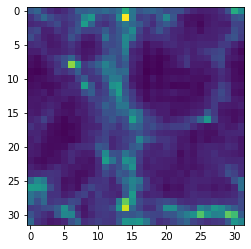

In [177]:
# Model trained on this distribution of 32^3 particles
plt.imshow(fin[0].numpy().sum(axis=0))

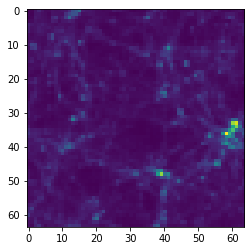

In [ ]:
# Distribution for validation on 64^3 particles
plt.imshow(fin[0].numpy().sum(axis=0))

### Helper functions

In [178]:
def cic_readout_features(mesh, part, name="CiCReadout"):
  """
  Reads out particles from mesh.
  Parameters: 
  ----------- 
  mesh: tensor (batch_size, nc, nc, nc, T)
      Input 4D mesh tensor with last axis of T features
  
  part: tensor (batch_size, npart, 3)
      List of 3D particle coordinates, assumed to be in mesh units if
  boxsize is None
  
  Return:
  -------
  value: tensor (batch_size, npart) 
      Value of the field sampled at the particle locations
  """
  with tf.name_scope("CiCReadoutFeatures"):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = [nx, ny, nz]

    # Flatten part if it's not already done                                                                                                                                                                                                                                                                                   
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles                                                                                                                                                                                                                                                   
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(
        tf.constant([[[0, 0, 0], [1., 0, 0], [0., 1, 0], [0., 0, 1],
                      [1., 1, 0], [1., 0, 1], [0., 1, 1], [1., 1, 1]]]), 0)

    neighboor_coords = tf.add(floor, connection)
    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords, nc)

    meshvals = tf.gather_nd(mesh, neighboor_coords, batch_dims=1)
    weightedvals = tf.multiply(meshvals, tf.expand_dims(kernel, -1))
    value = tf.reduce_sum(weightedvals, axis=-2)
    return value

def fftk(shape, symmetric=True, finite=False, dtype=np.float64):
    """ Return k_vector given a shape (nc, nc, nc) and box_size                                                                                                                                                                                                                                                                 
    """
    k = []
    for d in range(len(shape)):
        kd = np.fft.fftfreq(shape[d])
        kd *= 2 * np.pi
        kdshape = np.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) - 1:
            kd = kd[:shape[d] // 2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def laplace_kernel(kvec):
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1. / kk
    imask = (~(kk == 0)).astype(int)
    wts *= imask
    return wts
 
 
def gradient_kernel(kvec, direction, order=1):
    print(direction)
    wts = 1j * kvec[direction]
    wts = np.squeeze(wts)
    wts[len(wts) // 2] = 0
    wts = wts.reshape(kvec[direction].shape)
    return wts
  

def force(delta_k, x, factor=1):
    

    shape = delta_k.get_shape()
    nc = shape[1:]

    kvec = fftk(nc, symmetric=False)

    ndim = 3
    norm = nc[0] * nc[1] * nc[2]
    lap = tf.cast(laplace_kernel(kvec), tf.complex64)
    pot_k = tf.multiply(delta_k, lap)

    f = []
    for d in range(ndim):
        force_dc = tf.multiply(pot_k, gradient_kernel(kvec, d))
        forced = c2r3d(force_dc, norm=norm)
        force = cic_readout(forced, x)
        f.append(force)

    f = tf.stack(f, axis=2)
    f = tf.multiply(f, factor)
    return f



## Data

In [179]:
B = 2
ncb = B*nc
print(ncb)
posb = pos*ncb/nc #convert to grid position of new mesh

mesh = tf.zeros([b_size, nc, nc, nc])
meshb = tf.zeros([b_size, ncb, ncb, ncb])

mesh = cic_paint(mesh, pos)
meshb = cic_paint(meshb, posb)

f = force(r2c3d(mesh), pos)
fb = force(r2c3d(meshb), posb)


64
0
1
2
0
1
2


In [180]:
# Our label y is the force difference F128-F64 - FOR TRAINING
y = f-fb
y

<tf.Tensor: shape=(3, 32768, 3), dtype=float32, numpy=
array([[[-2.4352431 , -2.1527982 , -1.0525234 ],
        [-2.327188  , -1.8185427 , -1.285395  ],
        [-1.1331983 , -0.6806962 , -1.6686393 ],
        ...,
        [-0.43117782,  0.1307404 , -1.2251606 ],
        [-0.57737154, -0.10274935, -1.2668805 ],
        [-0.7500053 , -0.16594034, -1.1325469 ]],

       [[ 0.09199119, -0.7081394 ,  0.6383015 ],
        [ 0.06924883, -0.7341775 ,  0.8837441 ],
        [ 0.25900424, -0.31390202,  0.84689844],
        ...,
        [-0.03826356, -0.7514343 ,  0.35456756],
        [ 0.04044428, -0.78040344,  0.69187397],
        [ 0.02462331, -0.8731054 ,  0.8148654 ]],

       [[-1.0232104 ,  0.7114981 ,  0.30743754],
        [-0.71984076,  1.6480619 ,  0.7623272 ],
        [-0.5448494 ,  2.198224  ,  0.38160607],
        ...,
        [-2.906272  , -1.8132901 ,  0.3964786 ],
        [-2.369598  , -1.3514234 , -0.46626967],
        [-1.9584961 , -0.84638274, -0.59688675]]], dtype=float32)>

In [ ]:
#  FOR VALIDATION on F128-F64
y = f-fb
y

<tf.Tensor: shape=(262144, 3), dtype=float32, numpy=
array([[ 1.1922451 , -0.3810821 , -2.1044633 ],
       [ 1.5294298 , -0.7237739 , -2.3729877 ],
       [-0.6104913 , -1.4711373 , -1.4790722 ],
       ...,
       [-0.21125332, -0.98500454,  3.322688  ],
       [ 0.75574654,  1.266088  , -0.9361831 ],
       [ 0.72133684,  0.5400971 , -0.28094792]], dtype=float32)>

In [ ]:
# Force difference along single direction
y_1d=y[:,:1]
y_1d.shape

TensorShape([32768, 1])

In [ ]:
y

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[-1.0001931 ,  0.22156766, -0.19476491],
       [-0.7509267 ,  0.19297454, -0.2883939 ],
       [-0.5113657 ,  0.00513565, -0.32553336],
       ...,
       [-1.3600236 ,  0.28904954,  0.34333253],
       [-1.3931649 ,  0.34980145,  0.23362252],
       [-1.2244287 ,  0.32971993, -0.01341859]], dtype=float32)>

### Input

In [224]:
# Adding channel dimension
ip_m = tf.expand_dims(fin,-1)
ip_shape   = ip_m.shape
ip_shape[1:]

TensorShape([32, 32, 32, 1])

In [182]:
#  Wrapping the input
ip_np  = ip_m.numpy()
in_pad = np.pad(ip_np, ((0,0),(3,3),(3,3),(3,3),(0,0)), mode='wrap')
in_wm  = tf.convert_to_tensor(in_pad) 
in_wm.shape

TensorShape([3, 38, 38, 38, 1])

In [183]:
# Shape after wrapping
ipw_shape = in_wm.shape
ipw_shape[1:]

TensorShape([38, 38, 38, 1])

## Model

In [225]:
  input_data = tf.keras.Input(shape = ipw_shape[1:])
  print("Shape of input:", input_data.shape)
  cnn1   = tfl.Conv3D(filters = 8, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'relu',data_format='channels_last')(input_data)
  print("Shape of cnn1:", cnn1.shape)
  cnn2   = tfl.Conv3D(filters = 8, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'relu',data_format='channels_last')(cnn1)
  print("Shape of cnn2:", cnn2.shape)
  cnn3   = tfl.Conv3D(filters = 4, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'linear',data_format='channels_last')(cnn2)
  print("Shape of cnn3:", cnn3.shape)
  p_pos  = cic_readout_features( cnn3 , pos)
  print("Shape of particle position:", p_pos.shape)
  split  = tf.split(p_pos,3, axis= 0)
  #print("Shape of split:", split.shape) 
  concat = tf.concat(split, 1)
  print("Shape of concat:", concat.shape)      
  p_p    = tf.squeeze(concat) #(append scale factor)
  print("Shape of MLP_input:", p_p.shape)
  MLP1   = tfl.Dense(64, activation = 'relu')(p_p)
  print("Shape of MLP1:", MLP1.shape)
  MLP2   = tfl.Dense(32, activation = 'relu')(MLP1)
  print("Shape of MLP2:", MLP2.shape)
  out    = tfl.Dense( 3, activation = 'linear')(MLP2)
  print("Shape of output:", out.shape)

  model = tf.keras.Model(inputs = input_data, outputs = out)

Shape of input: (None, 38, 38, 38, 1)
Shape of cnn1: (None, 36, 36, 36, 8)
Shape of cnn2: (None, 34, 34, 34, 8)
Shape of cnn3: (None, 32, 32, 32, 4)
Shape of particle position: (3, 32768, 4)
Shape of concat: (1, 98304, 4)
Shape of MLP_input: (98304, 4)
Shape of MLP1: (98304, 64)
Shape of MLP2: (98304, 32)
Shape of output: (98304, 3)


### Forward prop

In [206]:
F_prop = model(in_wm)

In [207]:
F_prop.shape

TensorShape([98304, 3])

### GradientTape 

In [226]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-3)
# Loss Fn
loss_fn = losses.MeanSquaredError()
batch_size = 3

#Training dataset

x_train, y_train = in_wm, y

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)



In [221]:
epochs   = 10
loss     = []

for epoch in range(epochs):
  #print("\nStart of epoch %d" % (epoch,))
   for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

  
    with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
 
        loss_value = loss_fn(y_batch_train, pred)
        loss.append(loss_value)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))



InvalidArgumentError: ignored

### Training and Checkpoints

In [215]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-3)
# Loss Fn
loss_fn = losses.MeanSquaredError()
#batch_size = 1

#Training dataset

x_train, y_train = in_wm, y


ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model= model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

def train_and_checkpoint(epochs, model, manager):
  ckpt.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")
  
  loss=[]
  for epoch in range(epochs):
  #print("\nStart of epoch %d" % (epoch,))
  
    with tf.GradientTape() as tape:
      pred = model(x_batch_train, training=True)

      loss_value = loss_fn(y_train, pred)
      loss.append(loss_value)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    ckpt.step.assign_add(1)
    if int(ckpt.step) % 10 == 0:
      save_path = manager.save()
      #print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

In [ ]:
train_and_checkpoint(5000, model, manager)

Restored from ./tf_ckpts/ckpt-2427


In [ ]:
train_and_checkpoint(5000, model, manager)

Restored from ./tf_ckpts/ckpt-500


In [ ]:
!ls ./tf_ckpts

checkpoint		      ckpt-915.data-00000-of-00001  ckpt-916.index
ckpt-914.data-00000-of-00001  ckpt-915.index
ckpt-914.index		      ckpt-916.data-00000-of-00001


### Single direction 

Min loss is 0.24658548831939697


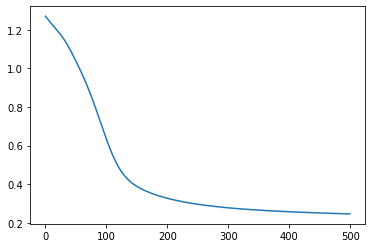

In [ ]:
# Loss for epoches = 500 with WRAP along single direction
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

Min loss is 0.20658430457115173


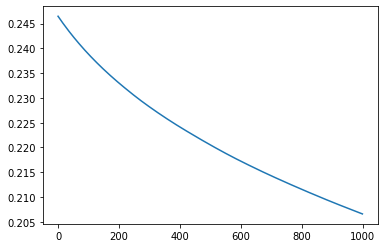

In [ ]:
# Loss for epoches = 1000 with WRAP along single direction
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

Min loss is 0.15647941827774048


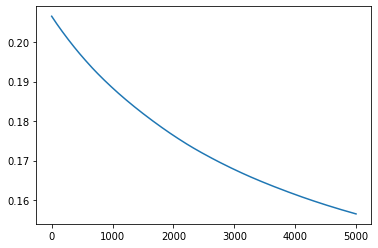

In [ ]:
# Loss for epoches = 5000 with WRAP along single direction
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

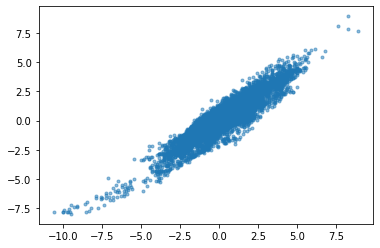

In [ ]:
# After training for 500 epochs
plt.plot(y_1d[:,0], F_prop[:,0],'.', alpha=0.5)

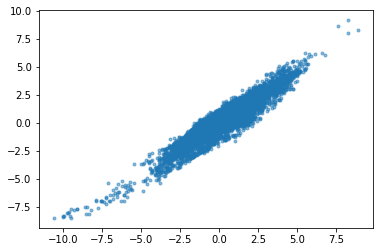

In [ ]:
# After training for 1000 epochs
plt.plot(y_1d[:,0], F_prop[:,0],'.', alpha=0.5)

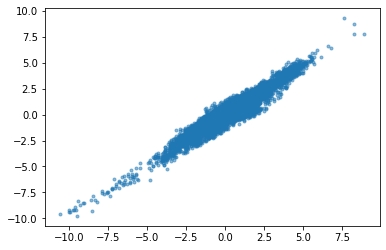

In [ ]:
# After training for 5000 epochs
plt.plot(y_1d[:,0], F_prop[:,0],'.', alpha=0.5)

In [ ]:
# Correlation coef after 500 epochs
for d in range(1):
    print(np.corrcoef(y_1d[:, d], F_prop[:, d]))

[[1.         0.89432017]
 [0.89432017 1.        ]]


In [ ]:
# Correlation coef after 1000 epochs
for d in range(1):
    print(np.corrcoef(y_1d[:, d], F_prop[:, d]))

[[1.        0.9122739]
 [0.9122739 1.       ]]


In [ ]:
# Correlation coef after 5000 epochs
for d in range(1):
    print(np.corrcoef(y_1d[:, d], F_prop[:, d]))

[[1.         0.93430086]
 [0.93430086 1.        ]]


### In three directions

Min loss is 0.9388041496276855


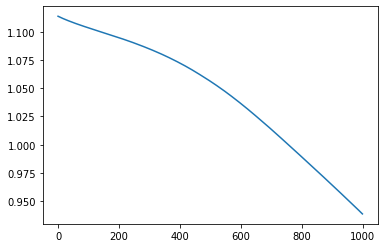

In [ ]:
# Loss for epoches = 1000 
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

Min loss is 2.9394919872283936


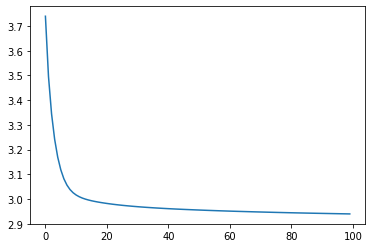

In [ ]:
# Loss for epoches = 500
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

Min loss is 0.33617979288101196


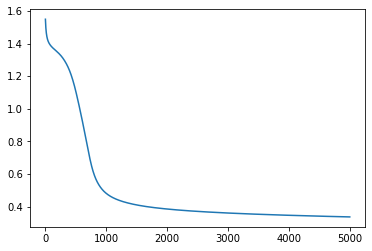

In [15]:
# Loss for epoches = 5000 
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

In [16]:
F_prop = model(in_wm)
f_c = f+ F_prop

Text(0.5, 0, 'F32')

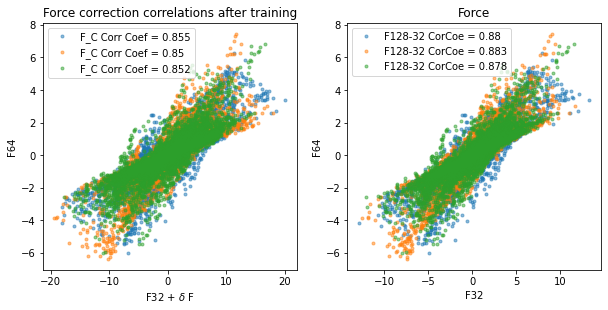

In [18]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(3):
    plt.plot(f_c[::, d], fb[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(f_c[:, d], fb[:, d])[0,1],3)}')

plt.title('Force correction correlations after training')
plt.legend()
plt.ylabel('F64')
plt.xlabel('F32 + $\delta$ F')

  
plt.subplot(2,2, 2)
for d in range(3):
    plt.plot(f[::, d], fb[::, d], '.', alpha=0.5, label=f'F128-32 CorCoe = {np.round(np.corrcoef(f[:, d], fb[:, d])[0,1],3)}' )

plt.title('Force')    
plt.legend()
plt.ylabel('F64')
plt.xlabel('F32')


In [188]:
tt= tf.convert_to_tensor([[[0,1,2],[30,31,32],[4,3,6]], [[10,11,21], [20,12,22],[14,13,16]], [[40,14,25],[20,14,24],[45,35,62]]])
tt

<tf.Tensor: shape=(3, 3, 3), dtype=int32, numpy=
array([[[ 0,  1,  2],
        [30, 31, 32],
        [ 4,  3,  6]],

       [[10, 11, 21],
        [20, 12, 22],
        [14, 13, 16]],

       [[40, 14, 25],
        [20, 14, 24],
        [45, 35, 62]]], dtype=int32)>

In [189]:
tf.split(tt,3, axis= 0)

[<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
 array([[[ 0,  1,  2],
         [30, 31, 32],
         [ 4,  3,  6]]], dtype=int32)>,
 <tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
 array([[[10, 11, 21],
         [20, 12, 22],
         [14, 13, 16]]], dtype=int32)>,
 <tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
 array([[[40, 14, 25],
         [20, 14, 24],
         [45, 35, 62]]], dtype=int32)>]

In [190]:
p_pos

<KerasTensor: shape=(3, 32768, 4) dtype=float32 (created by layer 'tf.math.reduce_sum_1')>

In [191]:
s1,s2,s3=tf.split(p_pos,3, axis= 0)

In [192]:
tf.concat([s1,s2,s3],1)

<KerasTensor: shape=(1, 98304, 4) dtype=float32 (created by layer 'tf.concat_1')>

In [160]:
t11 = tf.convert_to_tensor([[1, 2, 3], [4, 5, 6]])
t22 = tf.convert_to_tensor([[7, 8, 9], [10, 11, 12]])
tf.concat([t11, t22], 0)

<tf.Tensor: shape=(4, 3), dtype=int32, numpy=
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]], dtype=int32)>

In [162]:
t11

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)>

In [79]:
x1=tf.Variable(tf.random.uniform([5, 3], -1, 1))
tf.split(x1,3,1)

[<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[-0.47044444],
        [-0.0239563 ],
        [-0.8489702 ],
        [-0.1551075 ],
        [ 0.49099493]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 0.38186407],
        [-0.4756229 ],
        [ 0.9868908 ],
        [ 0.23255014],
        [-0.4489832 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[-0.04954958],
        [-0.6244428 ],
        [-0.694993  ],
        [ 0.06620741],
        [ 0.1020751 ]], dtype=float32)>]

In [44]:
t1

<tf.Tensor: shape=(1, 2, 3), dtype=int32, numpy=
array([[[0, 1, 2],
        [4, 3, 6]]], dtype=int32)>

In [45]:
t2

<tf.Tensor: shape=(1, 2, 3), dtype=int32, numpy=
array([[[10, 11, 21],
        [14, 13, 16]]], dtype=int32)>

In [51]:
tf.concat([t1,t2] ,1)

<tf.Tensor: shape=(1, 4, 3), dtype=int32, numpy=
array([[[ 0,  1,  2],
        [ 4,  3,  6],
        [10, 11, 21],
        [14, 13, 16]]], dtype=int32)>

In [ ]:
F_prop = model(in_wm)

Text(0.5, 0, 'F32')

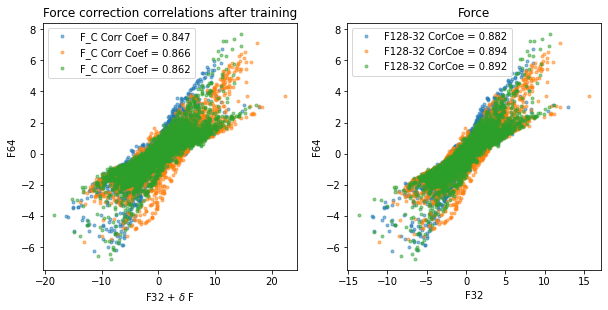

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(3):
    plt.plot(f_c[::, d], fb[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(f_c[:, d], fb[:, d])[0,1],3)}')

plt.title('Force correction correlations after training')
plt.legend()
plt.ylabel('F64')
plt.xlabel('F32 + $\delta$ F')

  
plt.subplot(2,2, 2)
for d in range(3):
    plt.plot(f[::, d], fb[::, d], '.', alpha=0.5, label=f'F128-32 CorCoe = {np.round(np.corrcoef(f[:, d], fb[:, d])[0,1],3)}' )

plt.title('Force')    
plt.legend()
plt.ylabel('F64')
plt.xlabel('F32')


In [ ]:
F_prop = model(in_wm)

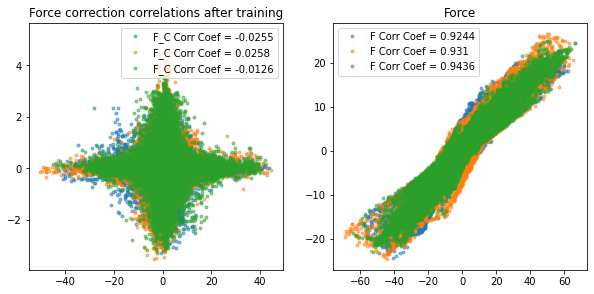

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(3):
    plt.plot(y[::, d], F_prop[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(y[:, d], F_prop[:, d])[0,1],4)}')

plt.title('Force correction correlations after training')
plt.legend()

  
plt.subplot(2,2, 2)
for d in range(3):
    plt.plot(f[::, d], fb[::, d], '.', alpha=0.5, label=f'F Corr Coef = {np.round(np.corrcoef(f[:, d], fb[:, d])[0,1],4)}' )

plt.title('Force')    
plt.legend()
plt.show()  

In [ ]:
for d in range(3):  
  print(np.corrcoef(f[:, d], fb[:, d])[0,1])

0.8640326459896458
0.8522151208420434
0.8694583406457206


In [ ]:
for d in range(3):  
  print(np.corrcoef(y[:, d], F_prop[:, d])[0,1])

0.8615356814883153
0.8611655453703082
0.8769147091751442
